> SLERP implemented in PyTorch with proper thresholding.  

In [ ]:
#| echo: false
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Introduction

This notebook introduces a native PyTorch implementation of [SLERP](https://en.wikipedia.org/wiki/Slerp). SLERP stands for "Spherical Linear Interpolation".  

It is a way of interpolating two vectors that keeps their length intact. We cover why this is important in the [Background](#Background) section below. In future posts, we'll use SLERP to combine the latent vectors of Diffusion models. 

# Background

The code is a refactor of a great numpy implementation by [@xsteenbrugge](https://twitter.com/xsteenbrugge). We can see an example of it in Andrej Karpathy's [Diffusion video script](https://gist.github.com/karpathy/00103b0037c5aaea32fe1da1af553355).

We also compare our SLERP to a short PyTorch implementation from [@ptrblck_de](https://twitter.com/ptrblck_de) in the [pytorch forums]( https://discuss.pytorch.org/t/help-regarding-slerp-function-for-generative-model-sampling/32475/4).  


Our SLERP doesn't cast tensors to and from numpy. But if GPU memory is at a premium (when is it not?), there is a flag `to_cpu` to compute SLERP on the CPU instead.  

This SLERP implementation uses a threshold on the dot product to avoid `nans` when the vectors are too close to parallel. Finally, our SLERP also has a helper `zdim` argument to process batched vectors.  

> **NOTE**: If you don't need to know about the theory, you can skip straight to the [code](#SLERP-Implementation).  


## Why do we need SLERP?  

SLERP is a way of interpolating vectors that preserves their overall magnitude. Why is this important for Diffusion models?  

It has to do with how our intuitions about Gaussians break down in higher dimensions. This [blog post](https://www.inference.vc/high-dimensional-gaussian-distributions-are-soap-bubble/) by Ferenc Huszár has an excellent description of exactly how our intuitions fail. His post also has many good visualizations that drive the point home.      

To summarize: a high-dimensional Gaussian is fundamentally different from the 1D "Bell curve" we are used to dealing with. 

As we climb to higher dimensions, the Guassian distribution turns into a thin, hollow shell. The probability density becomes spread out around this thin shell. Compare this to a typical 1D Gaussian. In the 1D case, most of the density is within a couple standard deviations of its mean.  

Before long, we are in a situation where the "inside" of the high-dimensional Gaussian is empty. Only its thin shell has any probability density. Borrowing Ferenc Huszár's excellent analogy: the distribution has become like a "soap bubble".  

Most Diffusion models are based on high-dimensional Gaussians. That means that when we talk about denoising latent spaces, we are in fact dealing with a series of high-dimensional soap bubbles.  

### Ok, so where does SLERP factor in?

Bringing it back to SLERP: if we use a regular linear interpolation, then our interpolated vector can easily "fly off" from the Gaussian soap film. We show an example below of how this happens even in 2D space.  

If we want to better travel the Diffusion latent space, we need to make sure that we stay on the thin surface of its Gaussian soap bubbles.  

## What about linear interpolation?  

In [ ]:
#| echo: false
def plot_vectors(*vects, labels=[], draw_unit_circle=True, colors=list(mcolors.TABLEAU_COLORS)):
    """Small helper to plot a series of unit vectors with labels. 
    
    Optionally adds a unit circle outline.
    """
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(1, 1, 1)
    
    # for reference, add a unit circle
    if draw_unit_circle:
        circ = plt.Circle((0, 0), radius=1, edgecolor='b', facecolor='None', linestyle=(5, (10, 3)))
        ax.add_patch(circ)
        
    # create the origin
    origin = [0 for _ in range(len(vects))]
    origin = np.array([origin, origin])
    
    # find the base and tips of the vectors
    base = [v[0] for v in vects]
    tips = [v[1] for v in vects]
    
    # find the colors we need
    colors = colors[:len(vects)] # TODO: what if we get more vectors than colors?
    
    # add labels if they were given
    if labels:
        for (v,lbl) in zip(vects, labels):
            beg, end = v
            ax.text(
                # some hacky padding to better align labels to the vectors
                beg + 0.045 if beg != 0 else beg,
                end + 0.045 if end != 0 else end, 
                lbl,
                fontsize='x-large',
            )
    
    # plot the vectors
    plt.quiver(*origin, base, tips, color=colors, angles='xy', scale_units='xy', scale=1)
    plt.xlim(-1.025, 1.25)
    plt.ylim(-1.025, 1.25)
    return fig

Regular linear interpolation (sometimes called LERP) has its rightful place. It is a cornerstone of computer graphics when we need to move an object between two points. In other words, LERP makes perfect sense if we only care about the position of the object along its interpolation path.  

You can think of LERP, in a way, like gravity: the shortest distance between two points is a straight line.  

For example: imagine we are drinking a cup of coffee and the mug is on the table. As we go to take a sip, we pick up the mug and bring it directly to our lips. Why would we swing our arm around in a weird pattern? That only makes the coffee take longer to get in our bellies.  

More generally, if we are moving objects in our familiar 3D world, we want to do the least amount of work. In a manner of speaking, we used LERP interpolation to bring the coffee mug to our lips.    


This example brings us back to why we need SLERP in the first place. Our intuitive notions of 3D paths break down in higher dimensions. In these higher-dimensions, LERP is not doing what we *think* it's doing and we are much better served by SLERP.   

### A concrete example of LERP

To make the points above tangible, let's see how linear interpolation works on vectors.  

For our example we can use the familiar $x$ and $y$ basis vectors. We also draw the Unit Circle for reference.  

> **NOTE**: the plotting function is available in the notebook. We omit it here for conciseness.  

In [ ]:
import torch

# use the X and Y axis unit vectors as an example
xhat = torch.tensor([1, 0]).float()
yhat = torch.tensor([0, 1]).float()

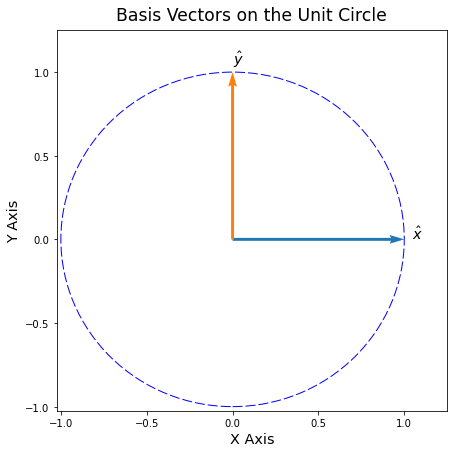

In [ ]:
# plot the basis vectors, with a unit circle outline
fig = plot_vectors(xhat, yhat, labels=['$\hat{x}$', '$\hat{y}$'], draw_unit_circle=True)
plt.xlabel('X Axis', fontsize='x-large')
plt.ylabel('Y Axis', fontsize='x-large')
plt.title('Basis Vectors on the Unit Circle', fontsize='xx-large', pad=10);

What happens when we linearly interpolate (LERP) these vectors to their midpoint?

In [ ]:
# compare against averaging the vectors
p_lerp = (xhat + yhat) / 2

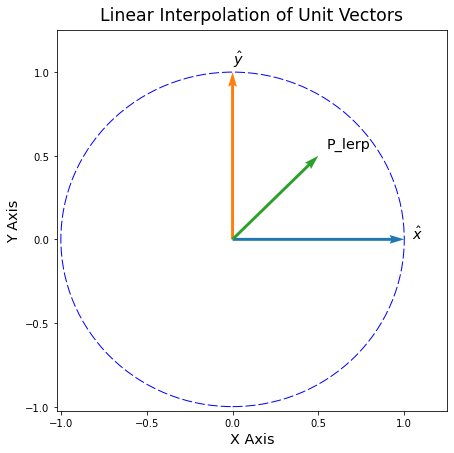

In [ ]:
# plotting the LERP of basis vectors x and y
fig = plot_vectors(xhat, yhat, p_lerp, labels=['$\hat{x}$', '$\hat{y}$', 'P_lerp'])
plt.xlabel('X Axis', fontsize='x-large')
plt.ylabel('Y Axis', fontsize='x-large')
plt.title('Linear Interpolation of Unit Vectors', fontsize='xx-large', pad=10);

If we only cared about getting from y to x, then we are on the right track! LERP is taking the shortest path possible.  

But now, think of the Unit Circle as representing a high-dimensional Gaussian soap bubble. The problem is the immediately clear...  The linear interpolation has taken us *off* the film surface of the soap bubble!  

To tie this situation to a 1D Gaussian example, it's as if we moved far, far away from our mean. Something like $+10$ $\sigma$ away. That would be an incredibly unlikely sample. 

With SLERP, we can still interpolate these unit vectors while staying firmly anchored to the soap bubble. Let's now define the function. 

# SLERP Implementation

In [ ]:
import torch 

def slerp(v1, v2, t, DOT_THR=0.9995, to_cpu=False, zdim=-1):
    """SLERP for pytorch tensors interpolating `v1` to `v2` with scale of `t`.
    
    Does a regular linear interpolation when the vectors are too close to parallel.
        I.E. when their dot product is above `DOT_THR`.  

    Theory Reference:
        https://splines.readthedocs.io/en/latest/rotation/slerp.html
    
    PyTorch reference:
        https://discuss.pytorch.org/t/help-regarding-slerp-function-for-generative-model-sampling/32475/3
        
    Numpy reference: 
        https://gist.github.com/dvschultz/3af50c40df002da3b751efab1daddf2c
    """
    
    # check if we need to compute on the cpu
    if to_cpu:
        orig_device = v1.device
        v1, v2 = v1.to('cpu'), v2.to('cpu')
    
    # take the dot product between normalized vectors
    v1_norm = v1 / torch.norm(v1, dim=zdim, keepdim=True)
    v2_norm = v2 / torch.norm(v2, dim=zdim, keepdim=True)
    dot = (v1_norm * v2_norm).sum(zdim)
    
    # if the vectors are too close, return a simple linear interpolation
    if (torch.abs(dot) > DOT_THR).any():
        print(f'warning: v1 and v2 close to parallel, using linear interpolation instead.')
        res = (1 - t) * v1 + t * v2    
    
    # else, apply SLERP
    else:
        # compute the angle terms we need
        theta   = torch.acos(dot)
        theta_t = theta * t
        sin_theta   = torch.sin(theta)
        sin_theta_t = torch.sin(theta_t)
        
        # compute the sine scaling terms for the vectors
        s1 = torch.sin(theta - theta_t) / sin_theta
        s2 = sin_theta_t / sin_theta
        
        # interpolate the vectors
        res = (s1.unsqueeze(zdim) * v1) + (s2.unsqueeze(zdim) * v2)
        
    # check if we need to move back to the original device
    if to_cpu: res.to(orig_device)
        
    return res

## SLERP interpolation on the unit vectors

What happens if we interpolate the unit vectors with SLERP instead? 

In [ ]:
# SLERP iterpolate unit vectors to their midpoint
p = slerp(xhat, yhat, 0.5)

Let's draw the SLERP-interpolated vector.

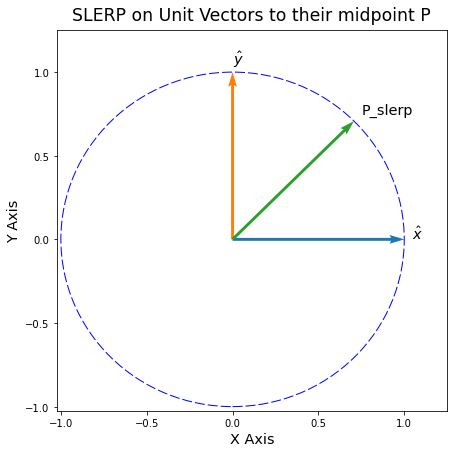

In [ ]:
# plot the SLERP iterpolated vector
fig = plot_vectors(xhat, yhat, p, labels=['$\hat{x}$', '$\hat{y}$', 'P_slerp'])
plt.xlabel('X Axis', fontsize='x-large')
plt.ylabel('Y Axis', fontsize='x-large')
plt.title('SLERP on Unit Vectors to their midpoint P', fontsize='xx-large', pad=10);

That looks much better!  

If the Unit Circle was like a Gaussian soap bubble, then we've properly moved along its film. 

# Conclusion

This notebook presented a PyTorch implementation of SLERP.  

We described what SLERP is and why we need it, compared to regular linear interpolation.  

Lastly, we drew some examples to make it clear why SLERP is better at interpolating high-dimensional vectors. 

In [ ]:
#| echo: false
#| include: false

'''
NOTE: geometric_slerp below, finding a basis for the vectors and using atan2 to find the angle.
''';

# def slerp_v1(start, end, t):
#     start = np.asarray(start, dtype=np.float64)
#     end = np.asarray(end, dtype=np.float64)
#     t = np.asarray(t)

#     if t.ndim > 1:
#         raise ValueError("The interpolation parameter "
#                          "value must be one dimensional.")

#     if start.ndim != 1 or end.ndim != 1:
#         raise ValueError("Start and end coordinates "
#                          "must be one-dimensional")

#     if start.size != end.size:
#         raise ValueError("The dimensions of start and "
#                          "end must match (have same size)")

#     if start.size < 2 or end.size < 2:
#         raise ValueError("The start and end coordinates must "
#                          "both be in at least two-dimensional "
#                          "space")

#     if np.array_equal(start, end):
#         return np.linspace(start, start, t.size)

#     # for points that violate equation for n-sphere
#     for coord in [start, end]:
#         if not np.allclose(np.linalg.norm(coord), 1.0,
#                            rtol=1e-9,
#                            atol=0):
#             raise ValueError("start and end are not"
#                              " on a unit n-sphere")

#     if not isinstance(tol, float):
#         raise ValueError("tol must be a float")
#     else:
#         tol = np.fabs(tol)

#     coord_dist = euclidean(start, end)

#     # diameter of 2 within tolerance means antipodes, which is a problem
#     # for all unit n-spheres (even the 0-sphere would have an ambiguous path)
#     if np.allclose(coord_dist, 2.0, rtol=0, atol=tol):
#         warnings.warn("start and end are antipodes"
#                       " using the specified tolerance;"
#                       " this may cause ambiguous slerp paths")

# def _geometric_slerp(start, end, t):
#     # create an orthogonal basis using QR decomposition
#     basis = np.vstack([start, end])
#     Q, R = np.linalg.qr(basis.T)
#     signs = 2 * (np.diag(R) >= 0) - 1
#     Q = Q.T * signs.T[:, None]
#     R = R.T * signs.T[:, None]

#     # calculate the angle between `start` and `end`
#     c = np.dot(start, end)
#     s = np.linalg.det(R)
#     omega = np.arctan2(s, c)

#     # interpolate
#     start, end = Q
#     s = np.sin(t * omega)
#     c = np.cos(t * omega)
#     return start * c[:, np.newaxis] + end * s[:, np.newaxis]